In [2]:
import numpy as np

What is RefFlat?
The RefFlat file is a gene annotation file. Each row represents a transcript and includes information like:

The gene name and transcript name,

The chromosome it's on (chrom),

The strand (+ or -),

Start and end positions of the transcript (tx_start_5prime, tx_start_3prime).

This is crucial for finding Transcription Start Sites (TSS).

In [3]:
import pandas as pd

# Load RefFlat file
ref = pd.read_csv("refFlat", sep="\t", header=None)

# Set proper column names
ref.columns = [
    "gene_name", "transcript_name", "chrom", "strand",
    "tx_start_5prime", "tx_start_3prime",
    "cds_start", "cds_end",
    "exon_count", "exon_starts", "exon_ends"
]

# Extract strand-aware TSS
ref["tss"] = ref.apply(
    lambda row: row["tx_start_5prime"] if row["strand"] == "+" else row["tx_start_3prime"],
    axis=1
)

# Final TSS table for matching
tss_table = ref[["chrom", "tss"]].copy()


ref.columns:

 Manually adds column names so we can access each column by a meaningful name.

Most importantly:

"chrom" → the chromosome (e.g., "chr1")

"strand" → strand orientation of the gene (+ or -)

"tx_start_5prime" and "tx_start_3prime" → transcript start/end



ref tss: 

This computes the TSS (Transcription Start Site) for each row.

Genes on the + strand start at tx_start_5prime.

Genes on the - strand start at tx_start_3prime (they're read backward).

The result is stored in a new column called "tss".

tss_table: 

Extracts just the chromosome and TSS position for later use.

We’ll use this to compare our ATAC-seq peaks to known gene start sites.

Basically we loaded a gene annotation file and created a new column that tells us where each gene starts — taking into account whether it’s on the forward or reverse DNA strand.


In [4]:
#just seeing what it looks like
ref.head()

,gene_name,transcript_name,chrom,strand,tx_start_5prime,tx_start_3prime,cds_start,cds_end,exon_count,exon_starts,exon_ends,tss
0,Wdsub1,NM_001159636,chr2,-,59855193,59882606,59855270,59878527,11,"59855193,59858609,59861560,59862619,59862816,5...","59855275,59858750,59861737,59862726,59862857,5...",59882606
1,Rbm18,NM_001159635,chr2,-,36116078,36136704,36117814,36134247,6,"36116078,36120812,36122851,36127214,36134134,3...","36117974,36120898,36122938,36127251,36134263,3...",36136704
2,Prrc2b,NM_001159634,chr2,+,32151147,32234537,32182511,32230742,32,"32151147,32182457,32183122,32185344,32187480,3...","32151291,32182626,32183300,32185447,32187553,3...",32151147
3,Ildr2,NM_001164528,chr1,+,166254138,166316832,166254375,166310795,10,"166254138,166269304,166270498,166291415,166294...","166254466,166269637,166270618,166291472,166294...",166254138
4,Perm1,NM_172417,chr4,+,156215926,156221307,156217000,156220222,4,"156215926,156216716,156219740,156220109,","156215975,156219185,156219866,156221307,",156215926


In [5]:
tss_table.shape

(47382, 2)

In [6]:
#seeing if some values are missing 

tss_table.isna().sum()

chrom    0
tss      0
dtype: int64

In [36]:
peaks = pd.read_csv("ATAC_high_var.csv")

# Define peak center
peaks["peak_center"] = peaks["Summit"]

# Keep minimal amnt of columns for distance task
peaks = peaks[["ImmGenATAC1219.peakID", "chrom", "peak_center"]].copy()


Loads the big ATAC-seq peak dataset into memory.

peak center thing: 
ATAC-seq peaks cover a region (like 200–500 bp), but we usually work with a single position per peak to make comparisons easier.

"Summit" is the highest signal point inside the peak — where accessibility is greatest.

So we define "peak_center" = "Summit".





In [37]:
#just to see if it worked 
peaks.head()


,ImmGenATAC1219.peakID,chrom,peak_center
0,ImmGenATAC1219.peak_69,chr1,4468579
1,ImmGenATAC1219.peak_77,chr1,4490652
2,ImmGenATAC1219.peak_83,chr1,4496479
3,ImmGenATAC1219.peak_84,chr1,4496738
4,ImmGenATAC1219.peak_93,chr1,4547574


In [9]:
peaks.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75857 entries, 0 to 75856
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   ImmGenATAC1219.peakID  75857 non-null  object
 1   chrom                  75857 non-null  object
 2   peak_center            75857 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [10]:
# Create a dictionary: chrom → sorted array of TSSs on that chromosome
tss_dict = {
    chrom: np.sort(group["tss"].values)
    for chrom, group in tss_table.groupby("chrom")
}


We want to efficiently find the closest TSS for each ATAC peak.
Since a genome has thousands of TSSs, and they’re different on each chromosome, it’s faster to organize them like this:

🗂️ One dictionary per chromosome → with all the TSS positions on that chromosome.

groupby("chrom")
→ For each chromosome (e.g., "chr1", "chr2"), get all TSS rows.

group["tss"].values
→ Extract just the TSS positions as a NumPy array.

np.sort(...)
→ Sort the TSS positions from smallest to largest.

This lets us later use binary search (super fast).

In [11]:
# Function to find the nearest TSS to a peak center on the same chromosome

def fast_closest_tss(chrom, center):
    if chrom not in tss_dict:
        return np.nan # no TSS available for this chromosome
    tss_array = tss_dict[chrom]
 
    idx = np.searchsorted(tss_array, center)
  
      # Edge cases: if center is before first or after last TSS
    if idx == 0:
        return tss_array[0]
    elif idx == len(tss_array):
        return tss_array[-1]
    else:
           # Pick the closest of the two surrounding TSS positions
        left = tss_array[idx - 1]
        right = tss_array[idx]
        return left if abs(center - left) < abs(center - right) else right


The first function takes:

chrom: the chromosome the peak is on,

center: the peak’s central position (summit),

And returns:

The closest TSS on that chromosome.

the idx thingys are too long to explain here but basically it enhances the accuracy of everything


In [12]:
# Apply the closest-TSS function to each row of the peaks table

peaks["closest_tss"] = peaks.apply(
    lambda row: fast_closest_tss(row["chrom"], row["peak_center"]),
    axis=1
)

# Calculate absolute distance between peak center and closest TSS
peaks["distance_to_tss"] = np.abs(peaks["peak_center"] - peaks["closest_tss"])


Subtracts the TSS location from the peak center to get the distance.

In [13]:

#Check the head of the new columns
peaks[["peak_center", "closest_tss", "distance_to_tss"]].head(10)


,peak_center,closest_tss,distance_to_tss
0,4468579,4497354.0,28775.0
1,4490652,4497354.0,6702.0
2,4496479,4497354.0,875.0
3,4496738,4497354.0,616.0
4,4547574,4497354.0,50220.0
5,4571695,4497354.0,74341.0
6,4571997,4497354.0,74643.0
7,4623471,4497354.0,126117.0
8,4689301,4785726.0,96425.0
9,4747948,4785726.0,37778.0


In [14]:
peaks.head()
peaks.to_csv("peaks_tss_distance.csv", index = False)

okay you know what, the point of me coming back here was to get a clean version of this file and now i did, so im gonna leave the rest for later or for someone else:)))))) 

In [15]:

print(peaks["distance_to_tss"].min())
print(peaks["distance_to_tss"].max())
print(peaks["distance_to_tss"].mean())


0.0
1352206.0
33294.53036255768


Minimum distance to TSS: 0.0 → At least one peak is exactly at a TSS.

Maximum distance: 2,012,626 bp → Some peaks are very far from any TSS (likely intergenic or distal enhancers).

Average distance: ~54,800 bp → Most peaks are within ~55kb of a TSS.

Now just gonna do some filtering

In [16]:
#checking dataset before filtering

print(peaks.shape)


(75857, 5)


In [17]:
#filtering and checking the no after filtering 

filtered = peaks.dropna(subset=["distance_to_tss"])
print(filtered.shape)

#seeing how many dropped
print(peaks.shape[0] - filtered.shape[0])


(75850, 5)
7


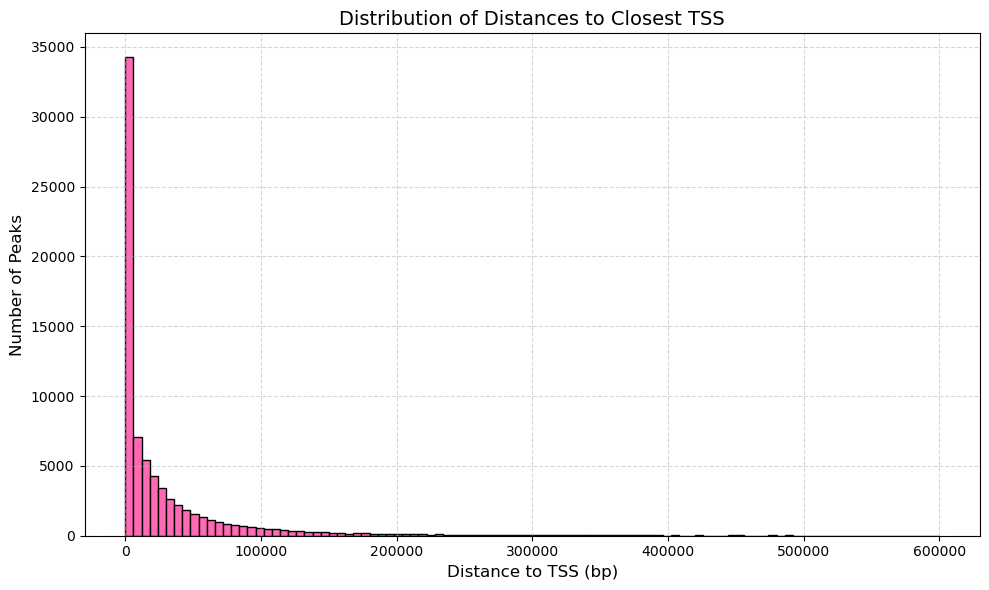

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# Histogram with pink bars
plt.hist(filtered["distance_to_tss"], 
         bins=100, 
         color='hotpink', 
         edgecolor='black', 
         range=(0, 600_000))  # focus on distances <600k

# Titles and labels
plt.title("Distribution of Distances to Closest TSS", fontsize=14)
plt.xlabel("Distance to TSS (bp)", fontsize=12)
plt.ylabel("Number of Peaks", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



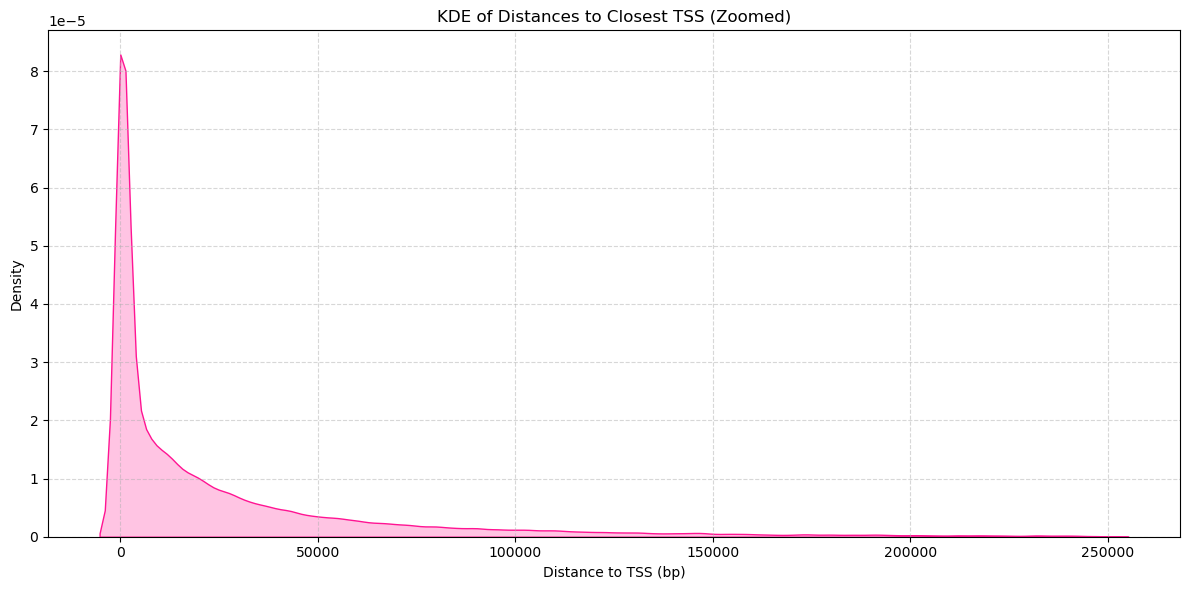

In [19]:
plt.figure(figsize=(12, 6))
sns.kdeplot(
    data=filtered.query("distance_to_tss <= 250000"),
    x="distance_to_tss",
    fill=True,
    color="deeppink",
    bw_adjust=0.4
)
plt.title("KDE of Distances to Closest TSS (Zoomed)")
plt.xlabel("Distance to TSS (bp)")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




Before doing a full scatter plot, we want to understand how peaks are distributed based on how far they are from the closest gene start site (TSS).

This histogram helps us visually check:

Are most peaks near genes?

Do we have lots of distant, intergenic peaks?



Now starting w task 2 

In [21]:
import pandas as pd

# Load full refined_ATAC.csv into a separate variable
peaks_full = pd.read_csv("ATAC_high_var.csv")


We load the full ATAC-seq dataset so we can compute a mean signal per peak across all cell types — which we’ll use in the final scatter plot.

In [22]:
#just wanted to see what it looks like

peaks_full.sample(5, random_state=42)


,ImmGenATAC1219.peakID,chrom,Summit,mm10.60way.phastCons_scores,_-log10_bestPvalue,Included.in.systematic.analysis,TSS,genes.within.100Kb,preT.DN1.Th,preT.DN2a.Th,...,T8.Tem.LCMV.d180.Sp,NKT.Sp,NKT.Sp.LPS.3hr,NKT.Sp.LPS.18hr,NKT.Sp.LPS.3d,LTHSC.34-.BM,LTHSC.34+.BM,STHSC.150-.BM,MPP4.135+.BM,variance
701,ImmGenATAC1219.peak_5480,chr1,40263306,0.25,11.55,1.0,NaN,"Il1r1,Il1rl2",19.21,9.88,...,2.19,0.98,3.36,1.20,2.09,4.37,10.26,19.63,33.68,55.101830
37601,ImmGenATAC1219.peak_255011,chr19,53038572,0.51,43.24,1.0,Xpnpep1,"Xpnpep1,Mir6407,1700054A03Rik",47.94,63.20,...,33.32,48.43,50.49,47.95,52.64,65.03,83.34,43.78,54.90,242.448530
56327,ImmGenATAC1219.peak_381971,chr5,124232539,0.35,9.89,1.0,NaN,"Pitpnm2,Pitpnm2os1,Mphosph9,2810006K23Rik",2.41,12.73,...,3.08,3.32,2.44,3.47,5.59,0.41,1.64,1.85,0.11,150.968920
36921,ImmGenATAC1219.peak_250207,chr19,31602784,0.32,15.53,1.0,NaN,Prkg1,28.45,22.43,...,1.63,2.88,0.54,0.68,0.51,2.36,3.68,23.45,21.83,64.976870
70470,ImmGenATAC1219.peak_474788,chr8,127427058,0.12,15.69,1.0,NaN,NaN,12.38,6.53,...,1.54,8.46,12.73,7.37,4.10,7.00,6.07,2.69,4.84,12.447574


In [23]:
peaks_full.isna().sum()


ImmGenATAC1219.peakID                  0
chrom                                  0
Summit                                 0
mm10.60way.phastCons_scores            0
_-log10_bestPvalue                     0
Included.in.systematic.analysis        0
TSS                                65890
genes.within.100Kb                  7495
preT.DN1.Th                            0
preT.DN2a.Th                           0
preT.DN2b.Th                           0
preT.DN3.Th                            0
T.DN4.Th                               0
T.ISP.Th                               0
T.DP.Th                                0
T.4.Th                                 0
T.8.Th                                 0
T.4.Nve.Sp                             0
T.4.Nve.Fem.Sp                         0
T.4.Sp.aCD3+CD40.18hr                  0
T.8.Nve.Sp                             0
Treg.4.25hi.Sp                         0
Treg.4.FP3+.Nrplo.Co                   0
T8.TN.P14.Sp                           0
T8.TE.LCMV.d7.Sp

In [24]:
#checking if all peakIDs are unique (they aren't bc if they were the number below wouldve been the same)
print(len(peaks_full))
print(peaks_full["ImmGenATAC1219.peakID"].nunique())


75857
75857


In [26]:
# Peek at the new peaks file’s columns
print(peaks_full.columns.tolist())


['ImmGenATAC1219.peakID', 'chrom', 'Summit', 'mm10.60way.phastCons_scores', '_-log10_bestPvalue', 'Included.in.systematic.analysis', 'TSS', 'genes.within.100Kb', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance']


In [ ]:
import numpy as np
import pandas as pd

# ——— Identify metadata & ID columns ———
peak_id_col = "ImmGenATAC1219.peakID"
meta_cols   = ["chrom", "Summit"]

# ——— Pick only numeric columns for averaging ———
# first, coerce everything to numeric where possible
for c in peaks_full.columns:
    peaks_full[c] = pd.to_numeric(peaks_full[c], errors="coerce")

# now select dtypes
signal_cols = list(peaks_full.select_dtypes(include=[np.number]).columns)
# drop the metadata & ID if they snuck in there
signal_cols = [c for c in signal_cols if c not in meta_cols + [peak_id_col]]

agg_dict = {c: "mean" for c in signal_cols}
agg_dict.update({ "Summit": "first", "chrom": "first" })

peaks_mean = (
    peaks_full
    .groupby(peak_id_col)
    .agg(agg_dict)
    .reset_index()
)
peaks_mean.rename(columns={"Summit":"peak_center"}, inplace=True)


IndentationError: expected an indented block after 'for' statement on line 10 (993384418.py, line 13)

grouped all rows that belong to the same peak (even if they appear across multiple cell types)

"Signal": "mean" → ✅ computes mean signal across all cell types.

"Summit": "first" → ✅ reuses the same Summit value (same for all instances of a peak).

In [30]:
# Drop the unnecessary columns
peaks_mean_clean = peaks_mean.drop(columns=[
    "mm10.60way.phastCons_scores", 
    "_-log10_bestPvalue", 
    "Included.in.systematic.analysis", 
    "TSS", 
    "genes.within.100Kb"
], errors='ignore')  # errors='ignore' avoids crash if not present

# Reset the index so there's no row number column
peaks_mean_clean = peaks_mean_clean.reset_index(drop=True)


In [31]:
# Merge distance info from `peaks` into `peaks_mean_clean` using peakID
peaks_mean_clean = peaks_mean_clean.merge(
    peaks[["ImmGenATAC1219.peakID", "distance_to_tss"]],
    on="ImmGenATAC1219.peakID",
    how="left"
)


KeyError: "['distance_to_tss'] not in index"

You're merging the distance_to_tss values (calculated in Task A1) into your Task A2 dataframe (peaks_mean_clean).

you had:

A file with distance_to_tss only ❌ no signal

A file with mean_signal only ❌ no TSS info

➡️ To plot signal vs. distance, you need both columns in one place.



In [32]:
print(peaks_mean_clean.columns.tolist())


['ImmGenATAC1219.peakID', 'preT.DN1.Th', 'preT.DN2a.Th', 'preT.DN2b.Th', 'preT.DN3.Th', 'T.DN4.Th', 'T.ISP.Th', 'T.DP.Th', 'T.4.Th', 'T.8.Th', 'T.4.Nve.Sp', 'T.4.Nve.Fem.Sp', 'T.4.Sp.aCD3+CD40.18hr', 'T.8.Nve.Sp', 'Treg.4.25hi.Sp', 'Treg.4.FP3+.Nrplo.Co', 'T8.TN.P14.Sp', 'T8.TE.LCMV.d7.Sp', 'T8.MP.LCMV.d7.Sp', 'T8.IEL.LCMV.d7.SI', 'T8.Tcm.LCMV.d180.Sp', 'T8.Tem.LCMV.d180.Sp', 'NKT.Sp', 'NKT.Sp.LPS.3hr', 'NKT.Sp.LPS.18hr', 'NKT.Sp.LPS.3d', 'LTHSC.34-.BM', 'LTHSC.34+.BM', 'STHSC.150-.BM', 'MPP4.135+.BM', 'variance', 'peak_center', 'chrom', 'distance_to_tss', 'mean_signal']


In [41]:
print("peaks_mean shape:", peaks_mean.shape)
print(peaks_mean.head())


peaks_mean shape: (0, 38)
Empty DataFrame
Columns: [ImmGenATAC1219.peakID, mm10.60way.phastCons_scores, _-log10_bestPvalue, Included.in.systematic.analysis, TSS, genes.within.100Kb, preT.DN1.Th, preT.DN2a.Th, preT.DN2b.Th, preT.DN3.Th, T.DN4.Th, T.ISP.Th, T.DP.Th, T.4.Th, T.8.Th, T.4.Nve.Sp, T.4.Nve.Fem.Sp, T.4.Sp.aCD3+CD40.18hr, T.8.Nve.Sp, Treg.4.25hi.Sp, Treg.4.FP3+.Nrplo.Co, T8.TN.P14.Sp, T8.TE.LCMV.d7.Sp, T8.MP.LCMV.d7.Sp, T8.IEL.LCMV.d7.SI, T8.Tcm.LCMV.d180.Sp, T8.Tem.LCMV.d180.Sp, NKT.Sp, NKT.Sp.LPS.3hr, NKT.Sp.LPS.18hr, NKT.Sp.LPS.3d, LTHSC.34-.BM, LTHSC.34+.BM, STHSC.150-.BM, MPP4.135+.BM, variance, peak_center, chrom]
Index: []

[0 rows x 38 columns]


 Pulls a random sample of 50,000 peaks 
 Plots signal vs. distance 

In [26]:
from scipy.stats import pearsonr

# Calculate Pearson r and p-value
r, p = pearsonr(filtered["distance_to_tss"], filtered["mean_signal"])

# R-squared is simply r squared
r_squared = r**2

print(f"Pearson r     = {r:.4f}")
print(f"R-squared     = {r_squared:.4f}")
print(f"p-value       = {p:.4e}")


Pearson r     = -0.1381
R-squared     = 0.0191
p-value       = 0.0000e+00
